# User guide for Conformal Prediction Classification 
First of all you need to have `numpy`, `pandas`, `seaborn` and `conformal-eval` installed to run this notebook with all examples.

In [1]:
#import sys
#!{sys.executable} -m pip install conformal-eval

Secondly we will import the packages required, both conformal-eval plot/metrics and Numpy for loading and matplotlib for showing how to customize figures.

In [2]:
from conf_eval import metrics, plot
import matplotlib.pyplot as plt # For customizations 
import numpy as np # Loading of data

# Set a different style and context
plot.update_plot_settings(context='talk', font_scale=1.5)

## Load data

Import the predictions from a Conformal predictor. We require that the p-values are presented in a matrix format (either Numpy ndarray or Pandas DataFrame), and that the p-values for class '0' are in the first column, class '1' in second column etc. The true labels for the examples should be given either as a 1 dimension Numpy ndarray or a Pandas Series object, where the labels must be the same '0', '1', ... as used by the p-value matrix. **Note** for classification the plotting functions generally work directly base on the p-values and the true labels input, compared to the regression functions that require computing metrics before plotting. This is mainly due to conformal regressors require a significance level to generate prediction intervals, whereas significance levels can be applied later on for conformal classifiers.

In [3]:
# Binary test-case
from conf_eval.cpsign import *

(true_labels, p_values, labels) = load_clf_predictions('../tests/resources/cpsign_clf_predictions.csv', y_true_col='target', sep=';')
true_labels[true_labels==-1] = 0 # Note that all functions require 0,1,.. labels
print(p_values.shape)

(233, 2)


In [4]:
# Multiclass test-case
from sklearn.datasets import load_iris
multiclass_target_names = load_iris().target_names
multiclass_data = np.genfromtxt('../tests/resources/multiclass.p-values.csv', delimiter=',')
# this file has first column as the true label and the remaining ones are p-values
multiclass_p_values = multiclass_data[:,1:]
multiclass_true_labels = multiclass_data[:,:1].astype(int)
print(multiclass_p_values.shape) # 3 columns - 3 classes

(50, 3)


## Compute metrics
Here are a few examples of metrics that can be computed, all located in the package `pharmbio.cp.metrics`.

In [5]:
# Calculate the fraction of errors for a set of significance levels
# Output ordered in the same order as the `sign_vals` input.
# First index of the tuple is the overall fraction of errors, then comes
# a matrix with errors for each class (one row per significance, one column per class)
metrics.frac_errors(true_labels, p_values, sign_vals=[.15,.25])

(array([0.12017167, 0.18454936]),
 array([[0.16      , 0.07407407],
        [0.24      , 0.12037037]], dtype=float32))

In [6]:
metrics.obs_fuzziness(true_labels, p_values)

0.1360179639484979

In [7]:
CM = metrics.confusion_matrix(true_labels, p_values, sign=0.2, labels=[-1,1])
CM

,-1,1
-1,80,9
1,25,94
Empty,0,0
Both,20,5


In [8]:
CM_multiclass = metrics.confusion_matrix(multiclass_true_labels, multiclass_p_values, sign=0.02, labels=multiclass_target_names)
CM_multiclass

,setosa,versicolor,virginica
setosa,19,0,0
versicolor,0,13,0
virginica,0,2,15
Empty,0,0,0
Correct Multi-set,0,1,0
Incorrect Multi-set,0,0,0


## Plotting calibration curves

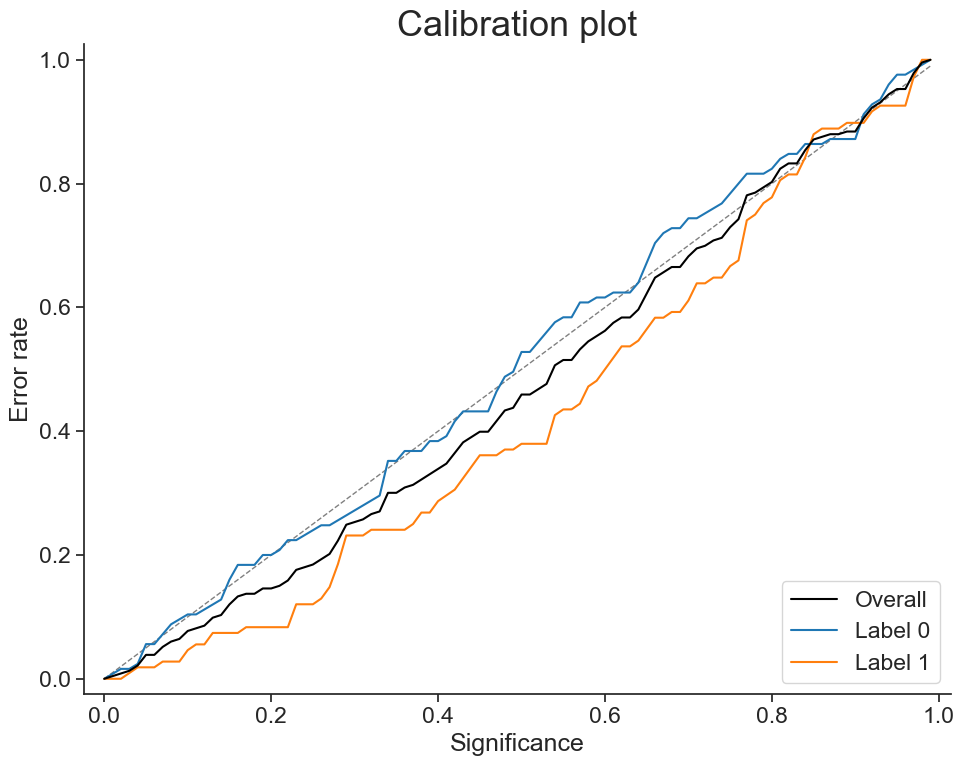

In [9]:
the_fig = plot.plot_calibration_clf(true_labels, p_values, title='Calibration plot')

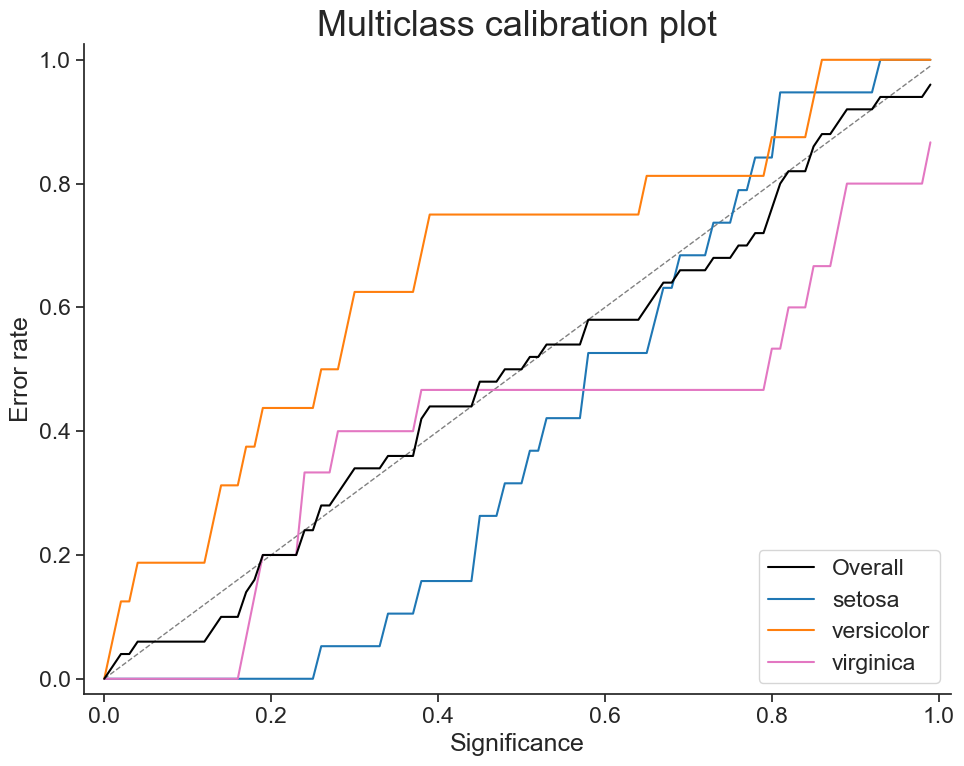

In [10]:
# Plot the output from the multi-class problem
mutliclass_fig = plot.plot_calibration_clf(multiclass_true_labels, 
                                                 multiclass_p_values, 
                                                 title='Multiclass calibration plot', 
                                                 labels=multiclass_target_names)


### Plotting with customization
Plotting can also be done in a smaller range of significance levels and has a few parameters to tweak the generated figure. Being based on matplotlib also allows easily customizations based on their APIs.

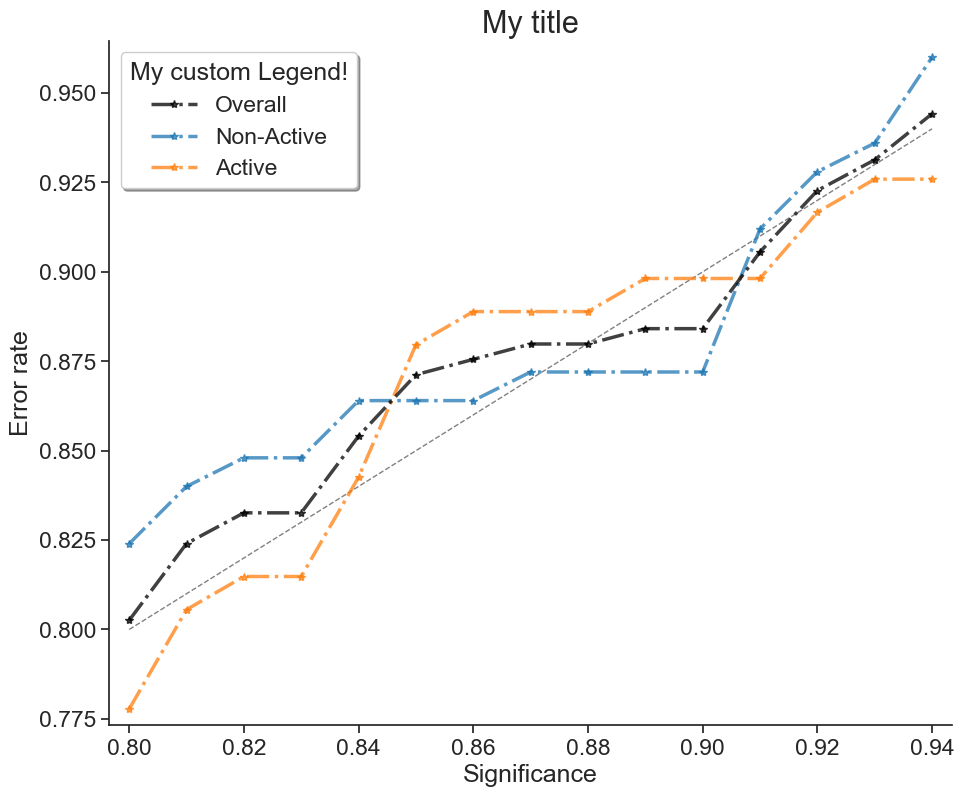

In [11]:
line_args = {'alpha': 0.75, 'marker':"*", 'linestyle': '-.', 'linewidth':2.5}

the_fig = plot.plot_calibration_clf(true_labels,
                                    p_values,
                                    sign_vals=np.arange(0.8,0.95,0.01),
                                    chart_padding=0.025,
                                    labels=["Non-Active", "Active"],
                                    **line_args)

# Get the axes to make customizations on
axes = the_fig.axes[0]

# Set a custom title
axes.set_title('My title', fontsize=22)

# Add a new (custom) legend
axes.legend(shadow=True,title='My custom Legend!')

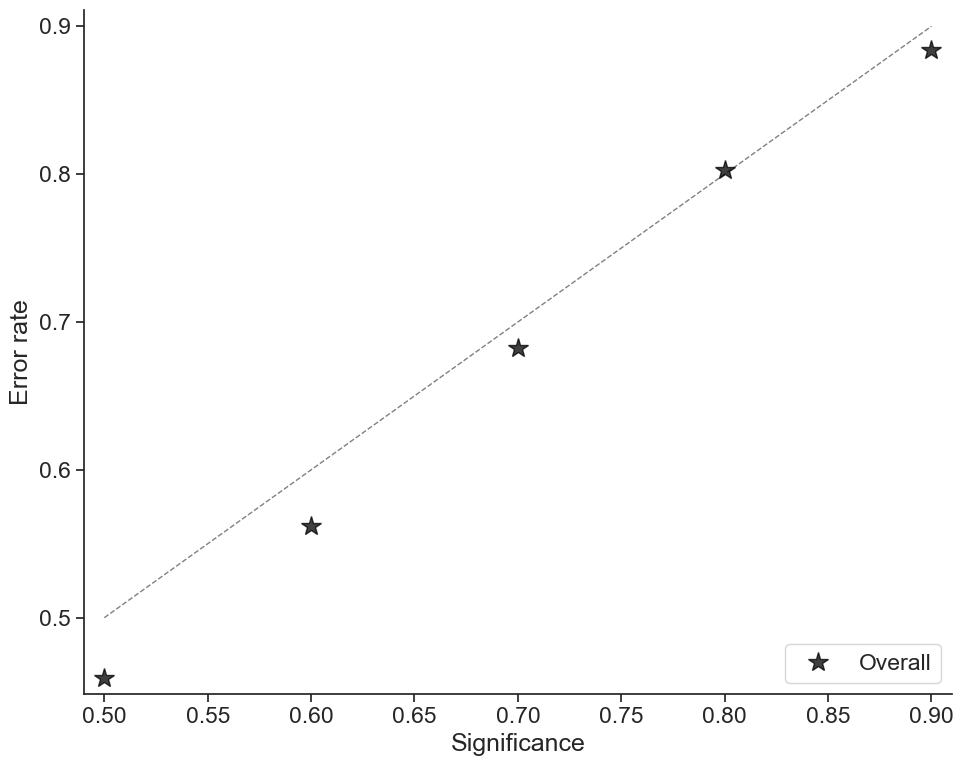

In [12]:
# Plot only a few descrete values rather than a continuous line

line_args = {'alpha': 0.75, 'marker':"*", 'ms': 15,'linestyle': 'None'}

the_fig = plot.plot_calibration_clf(true_labels,
                                    p_values,
                                    sign_vals=np.arange(0.5,1,0.1),
                                    labels=["Non-Active", "Active"],
                                    plot_all_labels=False,
                                    **line_args)

You can generate a calibration plot for a single class in many different ways (2 simple ways are):
- by only sending examples for that class and use the 'overall' curve
- specify the other colors with 0 alpha value (i.e. transparent)

Here we show the first of these alternatives

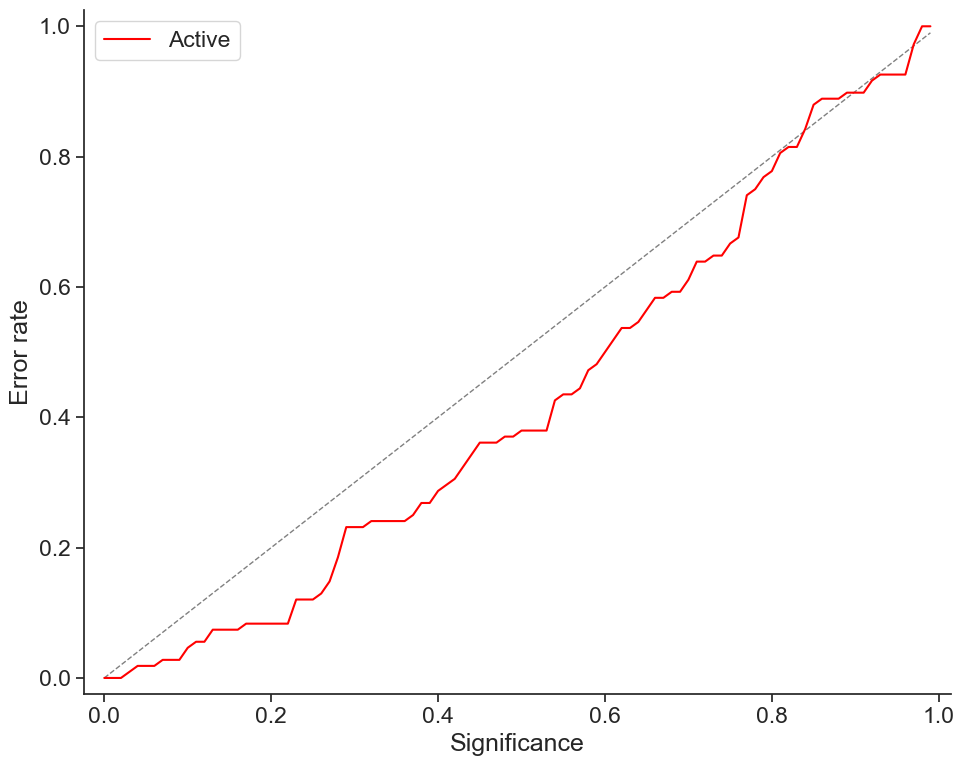

In [13]:
only_class_1 = (true_labels == 1)
true_1 = true_labels[only_class_1]
p_val_1 = p_values[only_class_1]
the_fig = plot.plot_calibration_clf(true_1, p_val_1,
                                    overall_color="red",
                                    plot_all_labels=False) 
# The legend specifies the curve as 'overall' - change this to the correct label name
the_fig.axes[0].legend().get_texts()[0].set_text('Active')

## Plotting p-values against each other

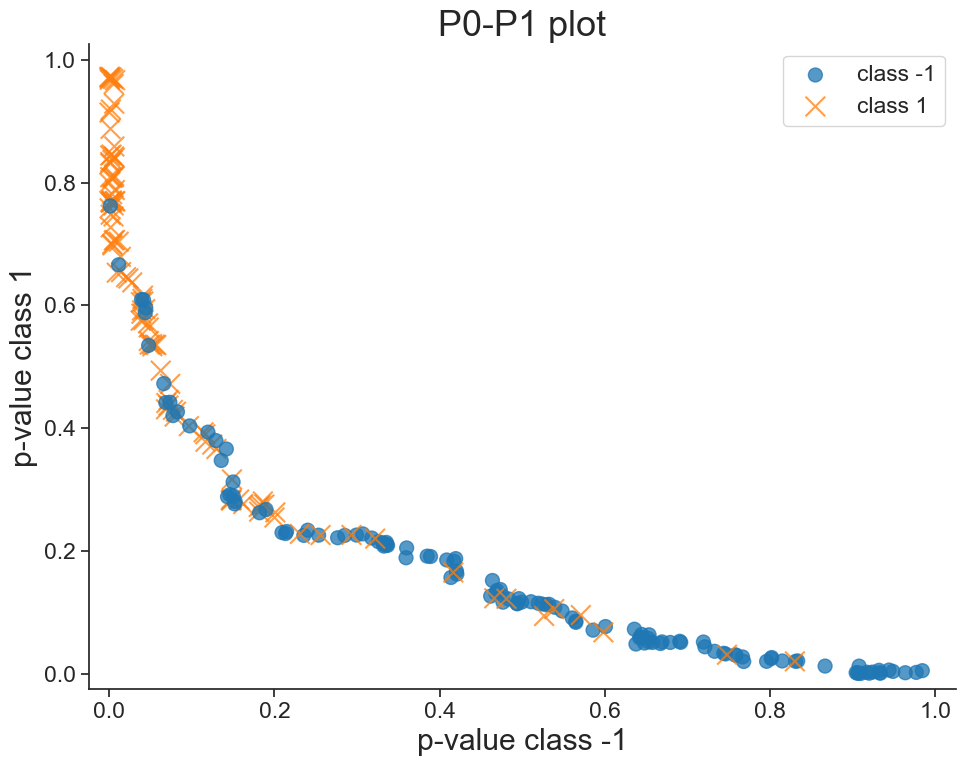

In [14]:
kwargs = {'alpha': 0.75} #, 'linewidth': 10} #, 'fontsize': 30}
font_args = None #{'fontsize':30}
marks = ['o','x']
s = [100, 200]
p0p1 = plot.plot_pvalues(true_labels,
                         p_values,
                         title='P0-P1 plot',
                         sizes=s,
                         markers=marks,
                         labels=['class -1', 'class 1'],
                         fontargs=font_args,
                         **kwargs)


## Plotting the distribution of prediction sets 

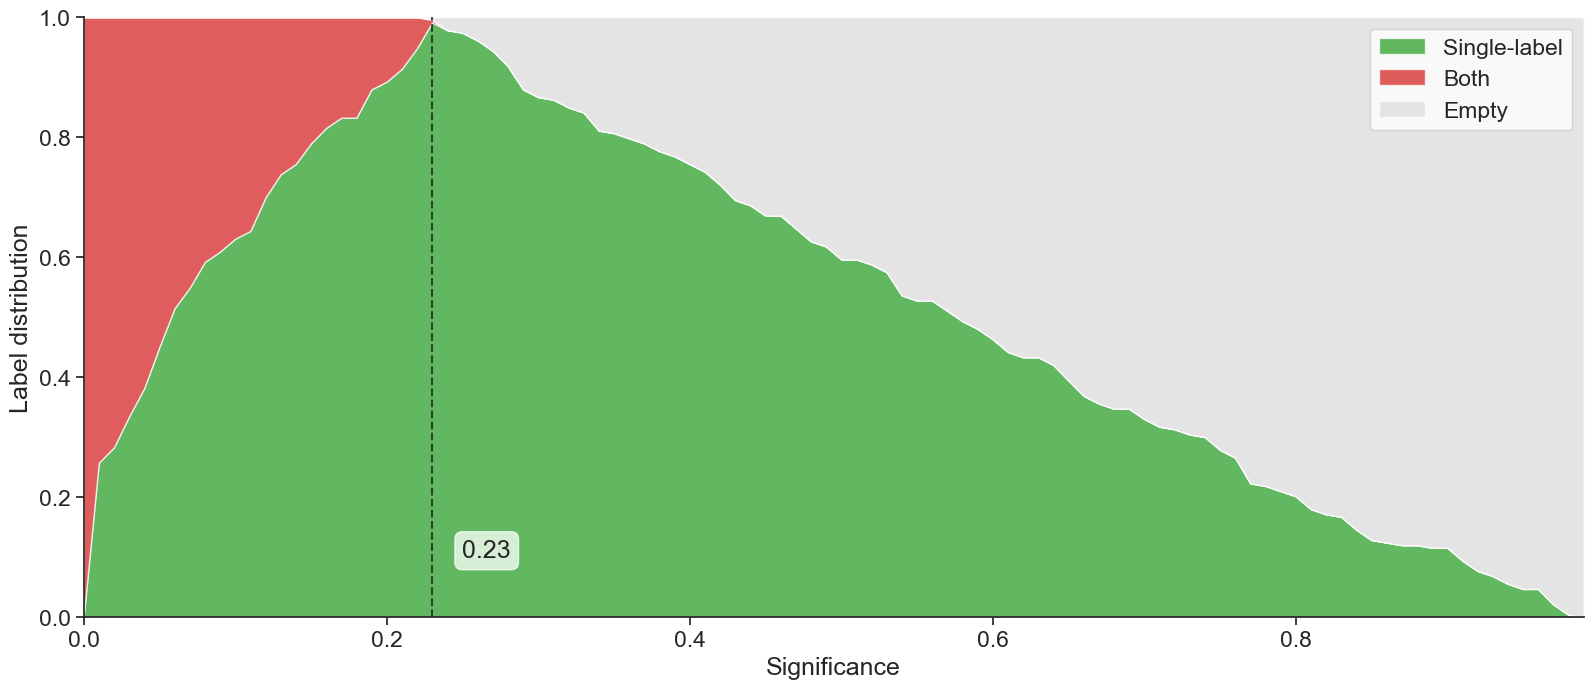

In [15]:
my_fig = plt.figure(figsize=(15,6))
ax = my_fig.add_axes([0,0,1,1])
custom_args = {'alpha': 0.75}
fig = plot.plot_label_distribution(y_true=true_labels,p_values=p_values, tight_layout=False, ax=ax, **custom_args)
# my_fig.savefig('area-plot.png',bbox_inches='tight')

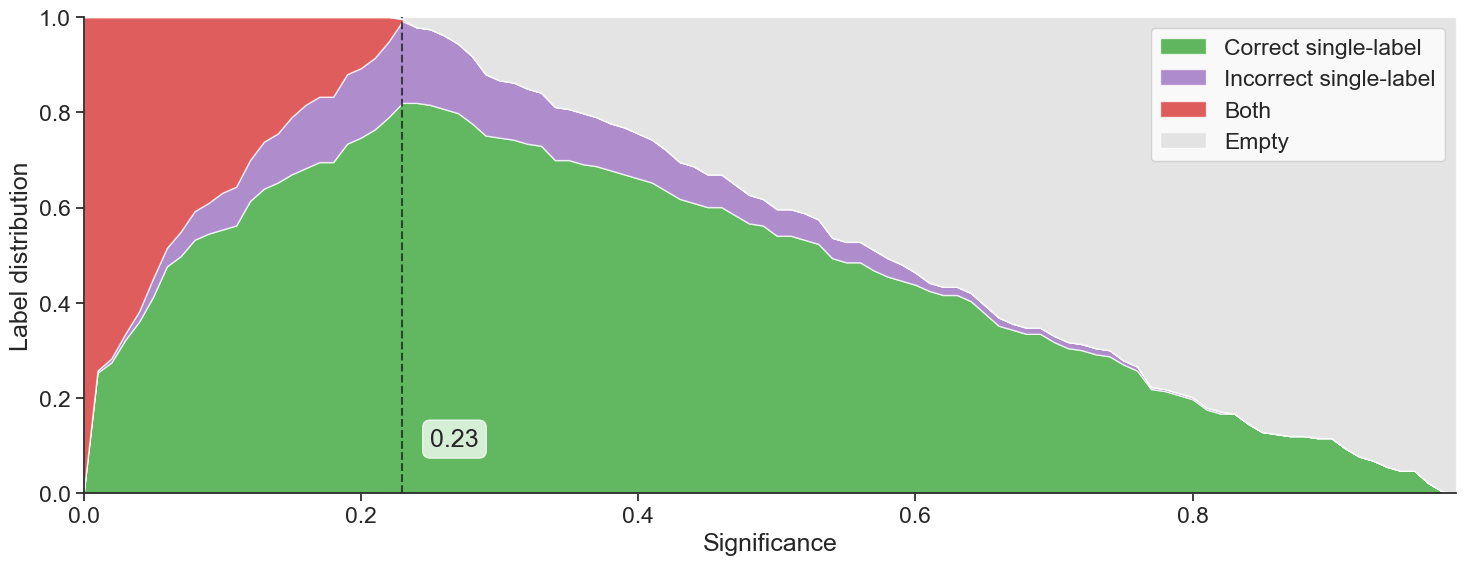

In [16]:
fig = plot.plot_label_distribution(y_true=true_labels,
                                   p_values=p_values,
                                   figsize=(15,6),
                                   display_incorrect=True,
                                   **custom_args)

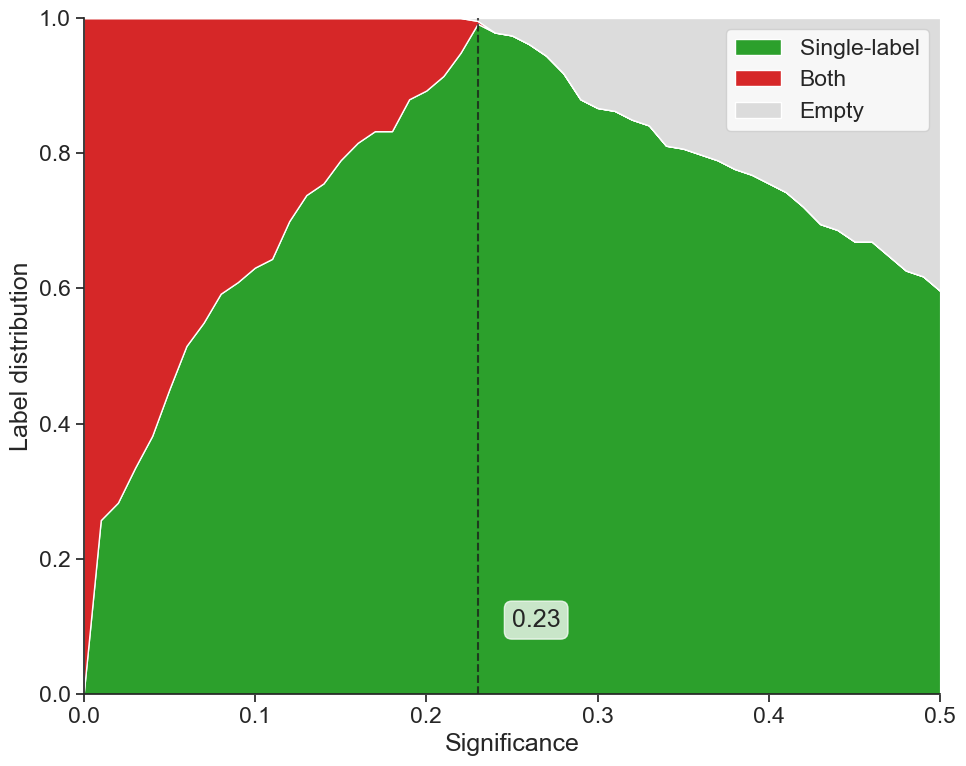

In [17]:
fig = plot.plot_label_distribution(y_true=true_labels, p_values=p_values, sign_vals=np.arange(0,.51,0.01))

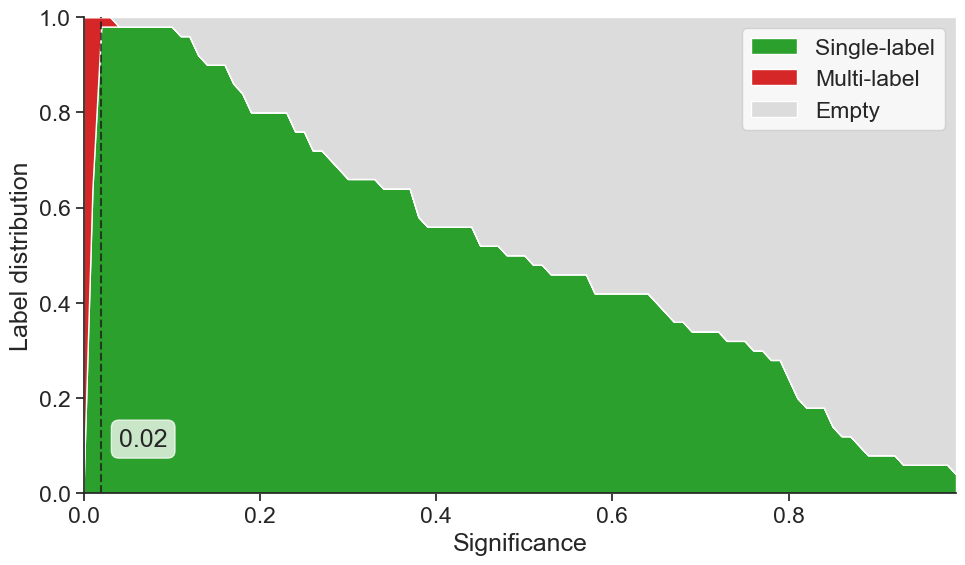

In [18]:
fig_multiclass = plot.plot_label_distribution(y_true=multiclass_true_labels,
                                              p_values=multiclass_p_values,
                                              figsize=(10,6))

## Plotting predictions using Bubble plots

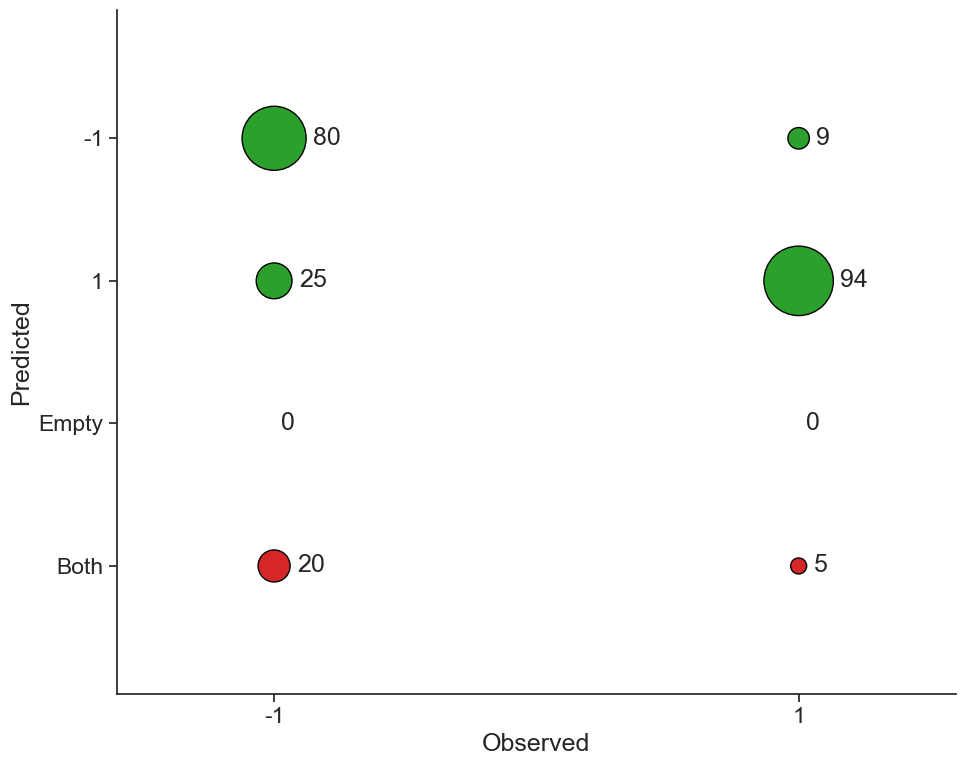

In [19]:
# We can use the confusion matrix computed earlier
bubble_plot = plot.plot_confusion_matrix_bubbles(confusion_matrix=CM)

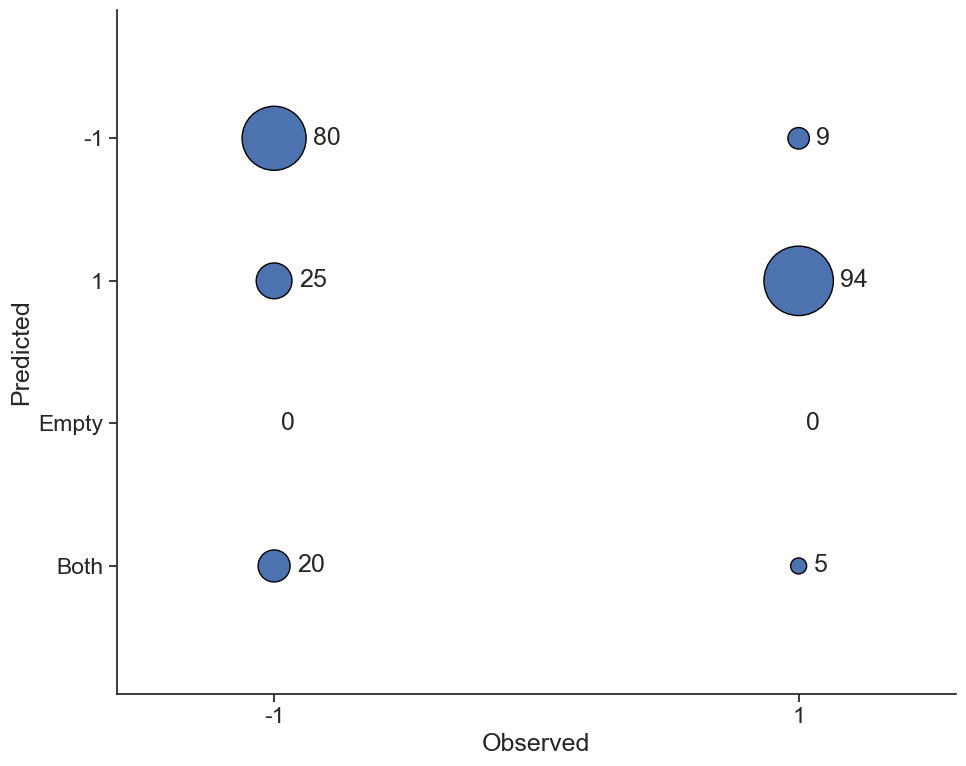

In [20]:
bubble_plot_none = plot.plot_confusion_matrix_bubbles(confusion_matrix=CM, color_scheme=None)

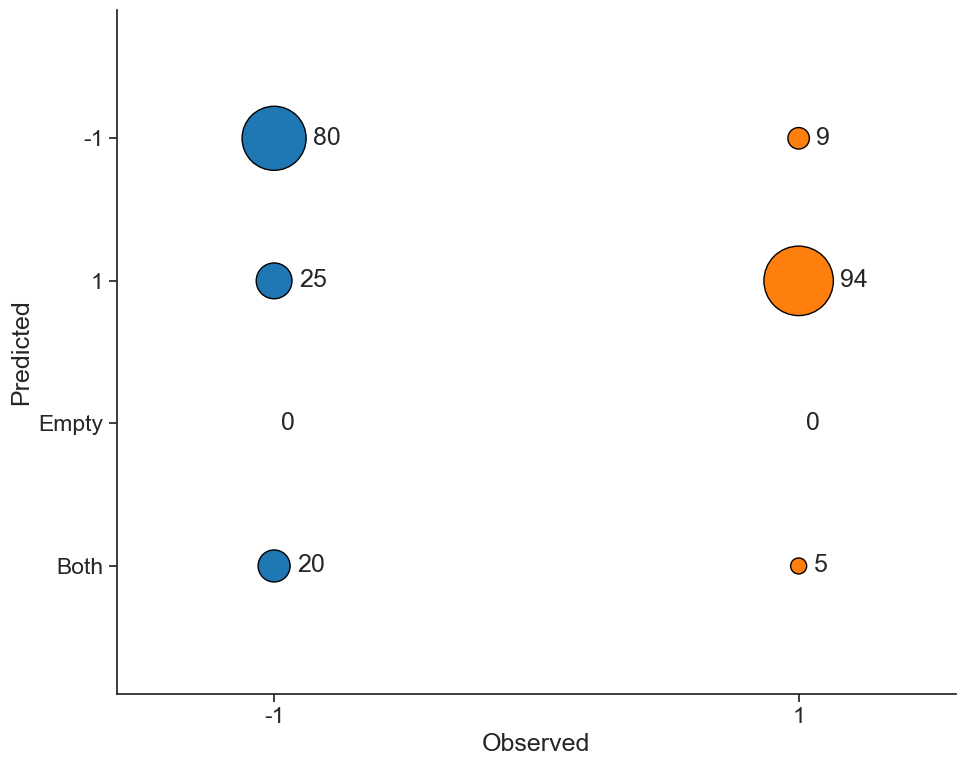

In [21]:
bubble_plot_label = plot.plot_confusion_matrix_bubbles(confusion_matrix=CM, color_scheme='label')

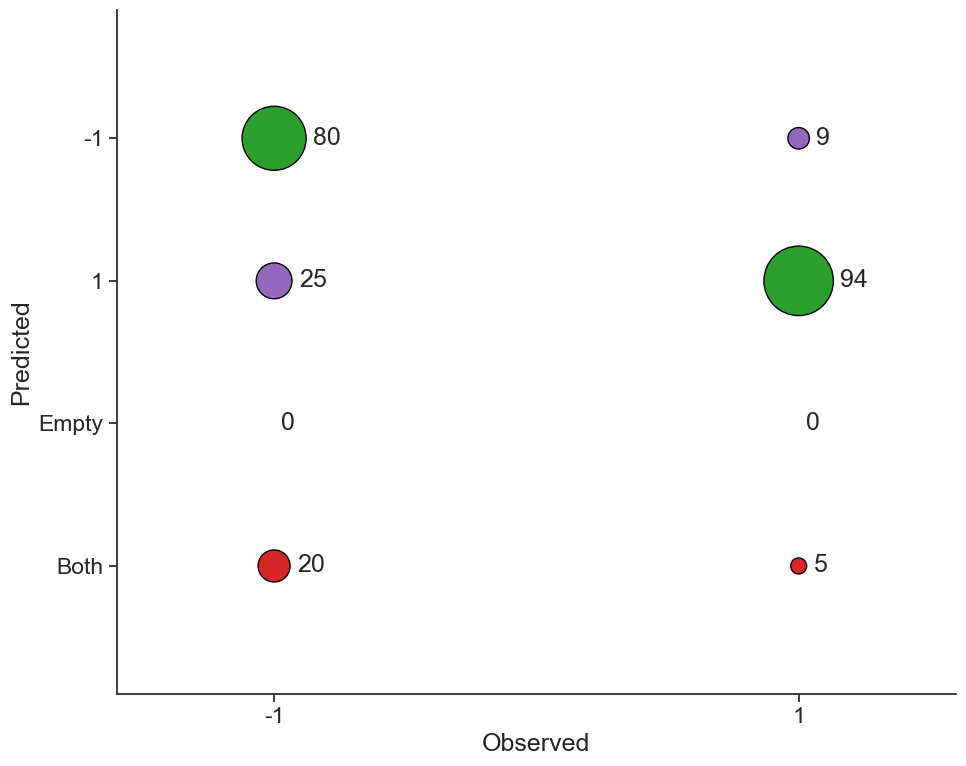

In [22]:
bubble_plot_label = plot.plot_confusion_matrix_bubbles(confusion_matrix=CM, 
                                                           color_scheme='full')

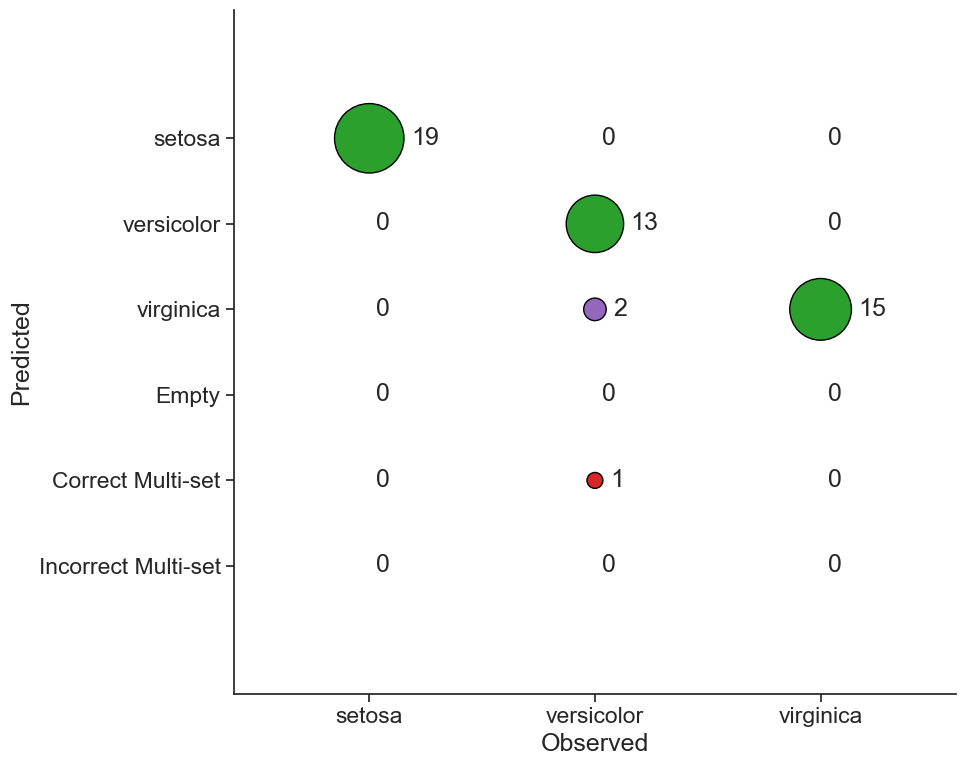

In [23]:
bubble_plot_label_multi = plot.plot_confusion_matrix_bubbles(confusion_matrix=CM_multiclass, 
                                                                 color_scheme='full')

Text(0.5, 1.0, 'Bubble plot')

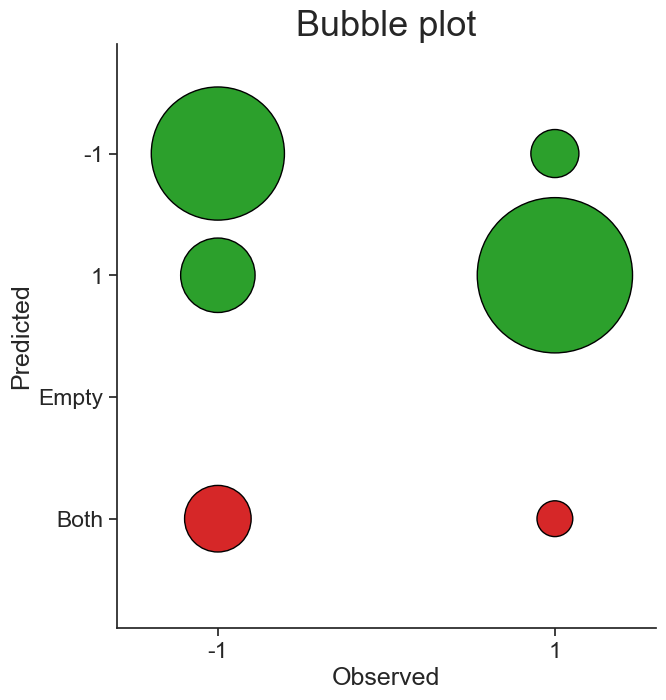

In [24]:
# Compute a normalized confusion matrix where each column sum to 1
CM_norm = metrics.confusion_matrix(true_labels, p_values, sign=0.2,
                                   labels=[-1,1], normalize_per_class=True)
# Remove the annotations and increase the size of the bubbles
bubble_plot_norm = plot.plot_confusion_matrix_bubbles(confusion_matrix=CM_norm,
                                                      annotate=False,
                                                      scale_factor=5,
                                                      figsize=7) # figure will be a 7x7 square 

bubble_plot_norm.axes[0].set_title('Bubble plot', fontdict={'fontsize': 'x-large'})

## Plotting heatmaps of a confusion matrix

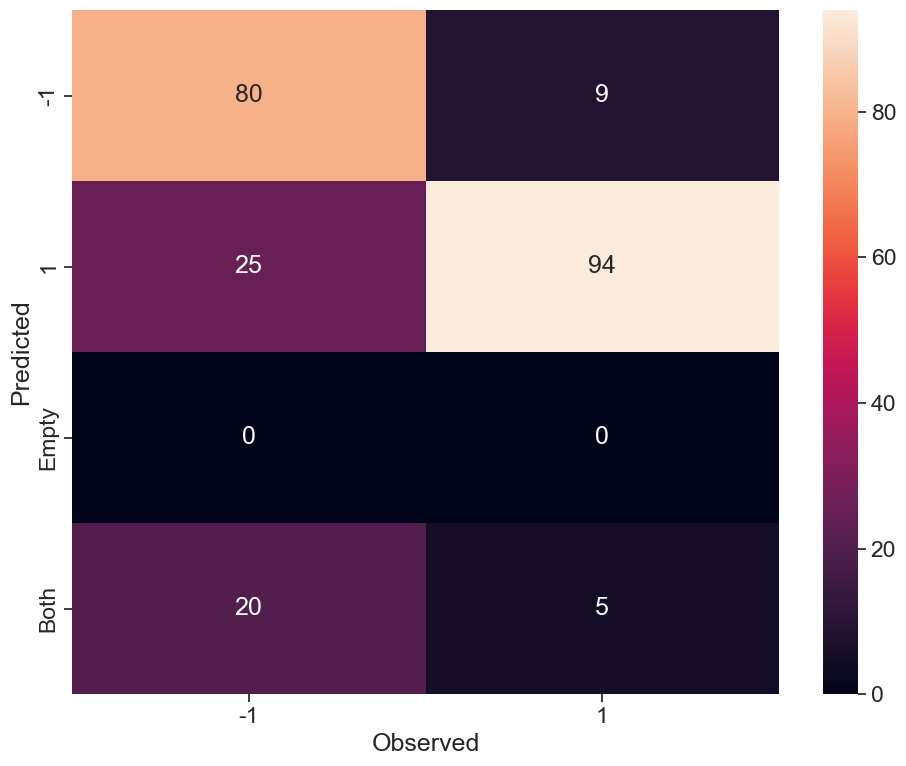

In [25]:
heat_m = plot.plot_confusion_matrix_heatmap(CM)

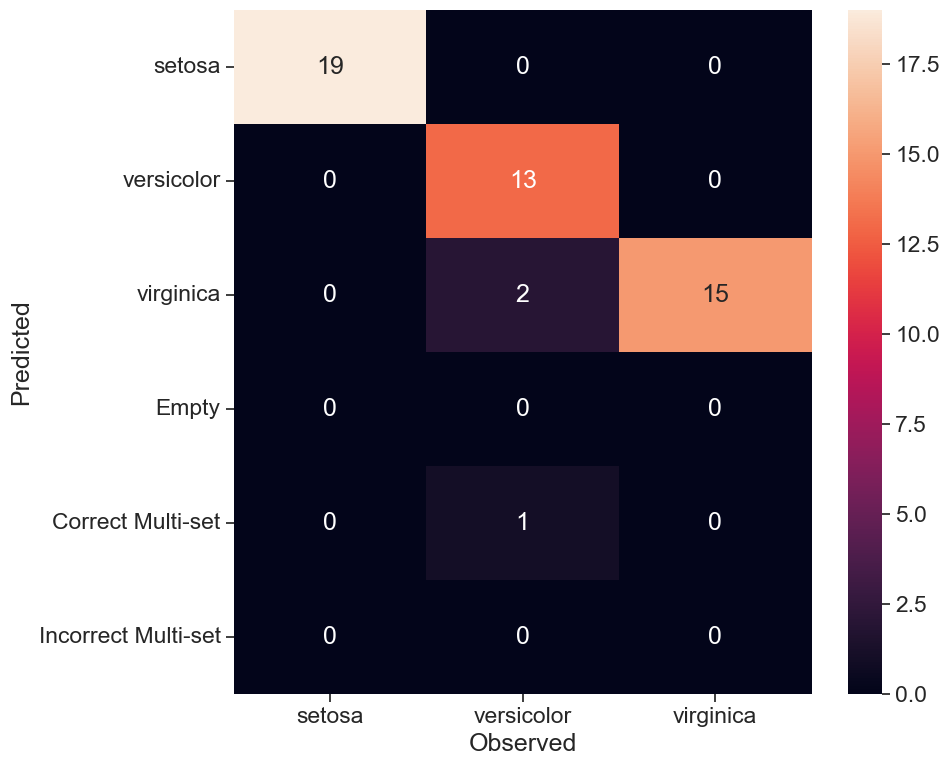

In [26]:
heat_m_multi = plot.plot_confusion_matrix_heatmap(CM_multiclass)

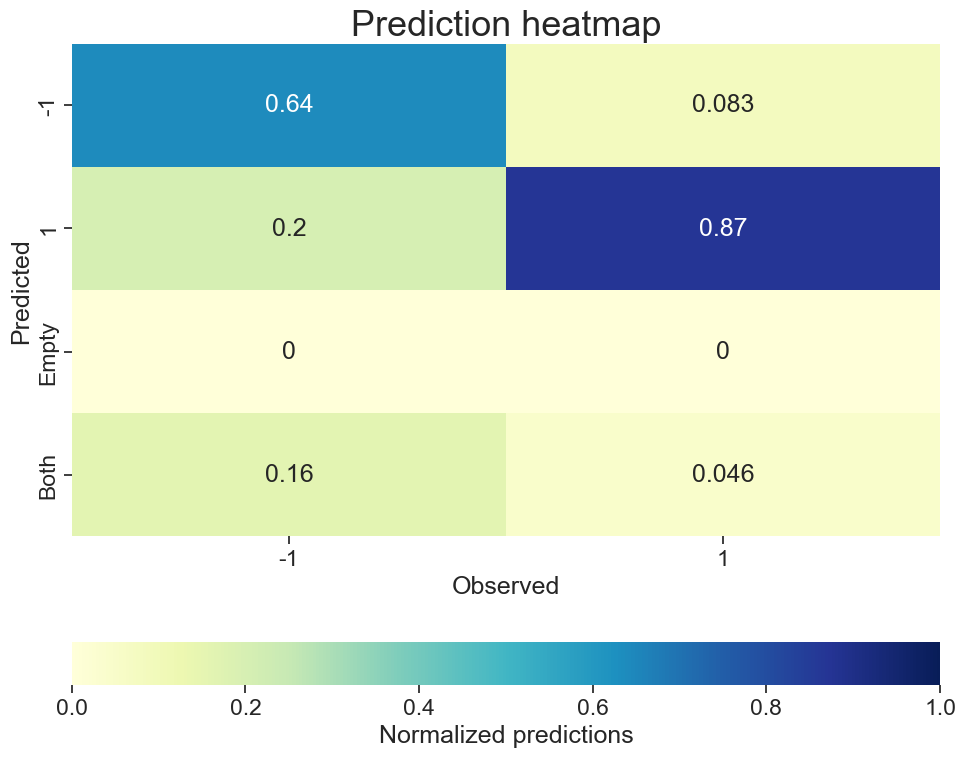

In [27]:
extra_args = {'vmax': 1,'cmap':"YlGnBu"} 
cbar_kws = {"orientation": "horizontal", 'label': 'Normalized predictions'}
heat_m_norm = plot.plot_confusion_matrix_heatmap(CM_norm, title="Prediction heatmap",
                                                 cbar_kws=cbar_kws,**extra_args)

## Example of joining mutliple plots in a grid

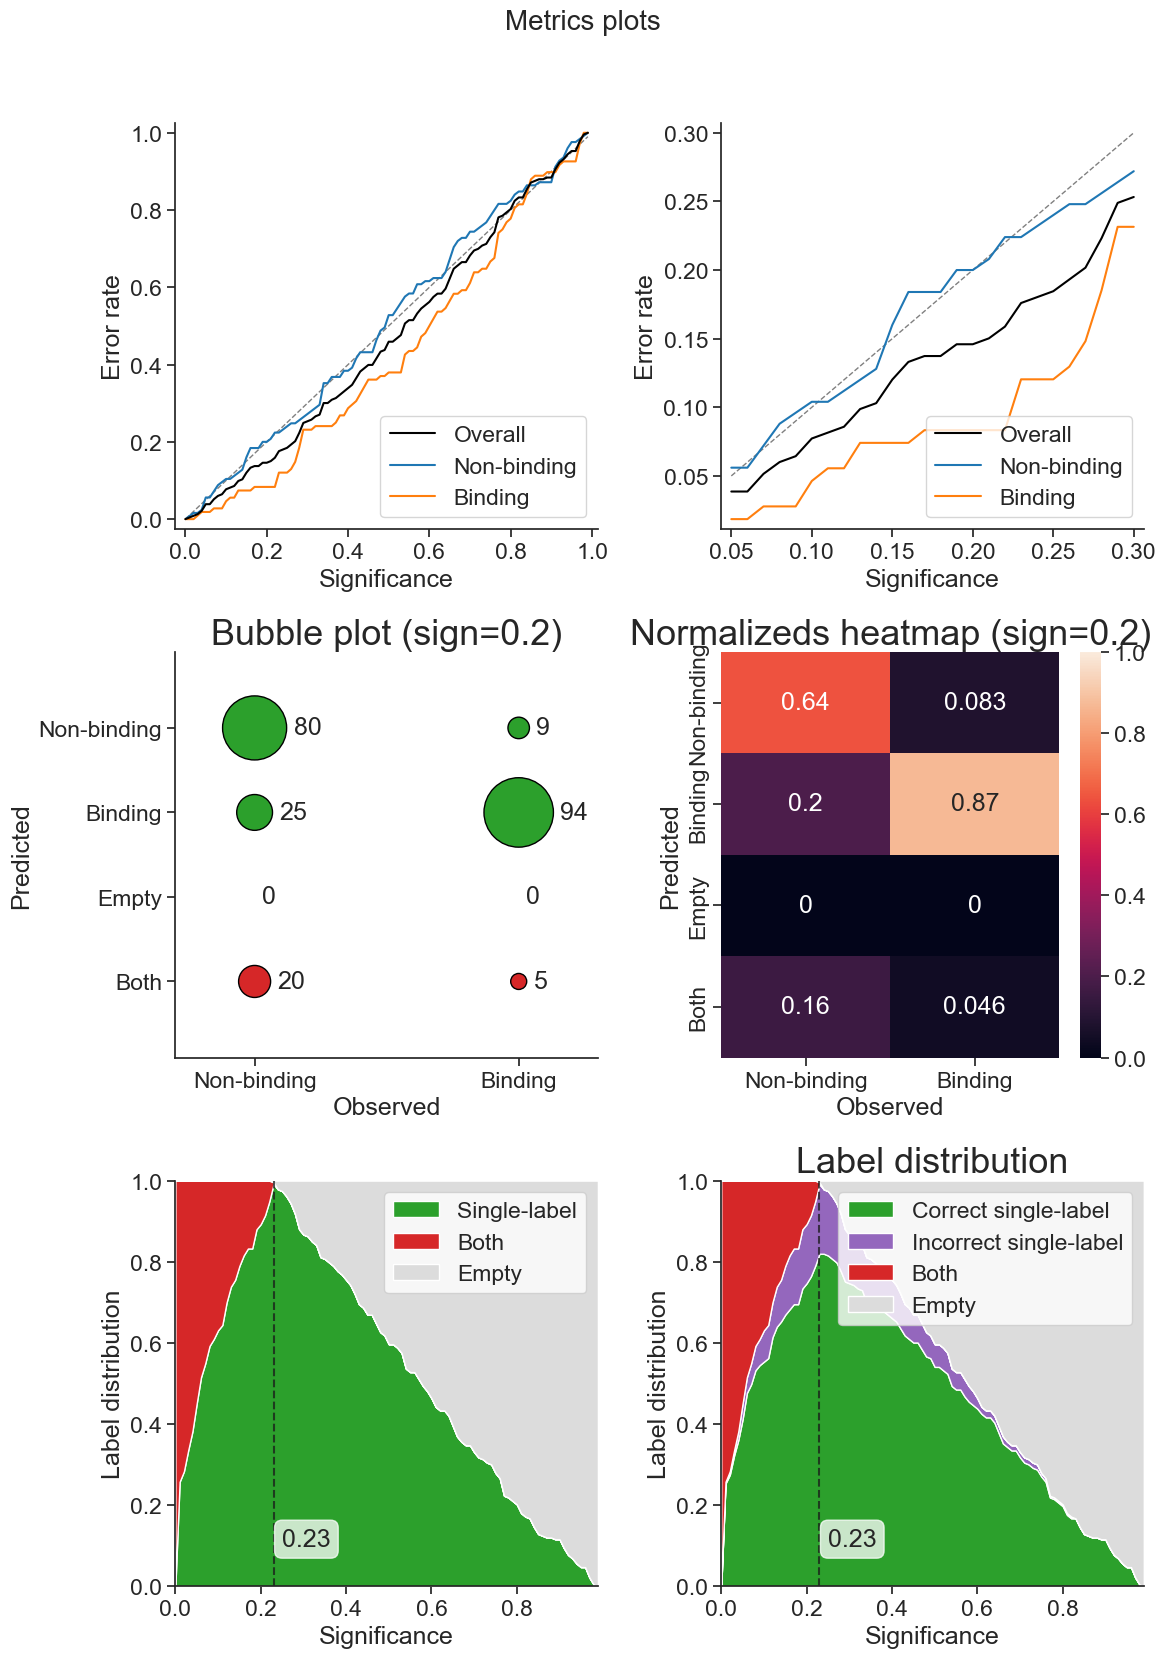

In [28]:
fig, axes = plt.subplots(3,2, figsize=(12,17))
class_labels=['Non-binding','Binding']
# Calibration plot
plot.plot_calibration_clf(true_labels, p_values, ax=axes[0,0], labels=class_labels)
#70-95% confidence only
plot.plot_calibration_clf(true_labels, p_values, ax=axes[0,1], sign_vals=np.arange(0.05,0.31,0.01), chart_padding=.025, labels=class_labels) 
plot.plot_confusion_matrix_bubbles(metrics.confusion_matrix(true_labels,p_values, .2, labels=class_labels),title="Bubble plot (sign=0.2)", ax=axes[1,0])
plot.plot_confusion_matrix_heatmap(metrics.confusion_matrix(true_labels,p_values, .2, labels=class_labels, normalize_per_class=True),vmin=0,vmax=1, ax=axes[1,1], title="Normalizeds heatmap (sign=0.2)")
plot.plot_label_distribution(y_true=true_labels,p_values=p_values, ax=axes[2,0])
plot.plot_label_distribution(y_true=true_labels,p_values=p_values, ax=axes[2,1], display_incorrect=True, title='Label distribution')
fig.suptitle('Metrics plots', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.96])